In [188]:
import random, warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import svm
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2})


## CCN demonstration plots

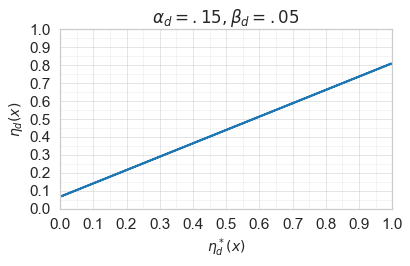

In [98]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(eta_star, eta_y)


# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.01, .1)
minor_ticks = np.arange(0, 1.01, .05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_xlim([0, 1])

ax.set_ylabel('$\eta_d(x)$', size=14)
ax.set_xlabel('$\eta_d^*(x)$', size=14)
ax.set_title(r'$\alpha_d=.15, \beta_d=.05$')
plt.tight_layout()
plt.savefig('true_proxy_cpf.png', dpi=400)

## Counterfactual estimation challenge intuition

In [205]:
def ccn_model(eta_star, beta, alpha):
    return (1 - beta - alpha)*eta_star + alpha

def eta(x, func='piecewise_linear'):
    if func=='sinusoid':
        return .5 + .5 * np.sin(2.9*x + .1)
    else: 
        return np.piecewise(x,[
            ((-1 <= x) & (x <= -.5)),
            ((-.5 < x) & (x <= 0.2069)),
            ((0.2069 < x) & (x <= 0.8)),
            ((0.8 < x) & (x <= 1))],  
            [lambda v: -1.5*v-.75, 
             lambda v: 1.4*v+.7,
             lambda v: -1.5*v+1.3,
             lambda v: 1.25*v - .9 ])
    

def pi(x, do, propfunc):
    if propfunc=='uniform': 
        pi = np.ones(x.shape)
    elif propfunc=='sine':
#         pi = .55 + .3*np.sin(4.45*x+.65)
        return 1-np.piecewise(x,[
            ((-1 <= x) & (x <= .5976)),
            ((.5976 < x) & (x <= 1))],  
            [lambda v: .55 + .3*np.sin(4.45*v+.65), 
             lambda v: .0001*v + .5])
#         pi = .6*(0.9 + 0.4 * np.sin(x))
    elif propfunc=='anchors':
        pi = .6+.2*np.sin(2.9*x+.1)
        
#         pi = np.piecewise(x,[((-1 <= x) & (x <= -.575)),
#                 ((-.575 < x) & (x <= 0.508)),
#                 ((0.508 < x) & (x <= 1))],  
#                        [lambda v: -.5*v-.096, 
#                         lambda v: 1/(1+np.exp(-2.5*v)),
#                         lambda v: -.5*v+1.035  ])

    return pi
    
def plot_tcn(eta_star, rand_intervention, show_propensity, show_samples):
    f, axs = plt.subplots(1, 2, sharey=False, figsize=(14,5))
    
    N=200
    
    for d in [0,1]:

        # Apply CCN noise model
        if d == 0:
            alpha_0, beta_0 = .1, .15
            eta_y = ccn_model(eta_star, beta=alpha_0, alpha=beta_0)
        else:
            alpha_1, beta_1 = .2, .05
            eta_y = ccn_model(eta_star, beta=alpha_1, alpha=beta_1)

        #Sample propensity function
        obs_outcome = np.random.binomial(1, pi(x, do=d, uniform=rand_intervention), size=eta_y.size)

        # Sample from proxy counterfactual class probability funcion
        samples_x = x[obs_outcome==1]
        samples_y = np.random.binomial(1, eta_y[obs_outcome==1], size=eta_y[obs_outcome==1].size)
        
        # Class probability functions
        axs[d].plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
        axs[d].plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')

        # Propensity function
        if show_propensity:
            axs[d].plot(x, pi(x, do=d, uniform=rand_intervention), label='$\pi(x)$', color='orange', linestyle='--')

        # Samples
        if show_samples:
            axs[d].scatter(samples_x[samples_y==1], samples_y[samples_y==1], marker='+', color='black', label=f'$Y_{d}=1$')
            axs[d].scatter(samples_x[samples_y==0], samples_y[samples_y==0], marker='o', color='black', label=f'$Y_{d}=0$')

        # Plot grid
        axs[d].set_xticks(np.arange(-1.0, 1.02, .2), fontsize=20)
        axs[d].set_yticks(np.arange(0.0, 1.01, .2), fontsize=20)
        axs[d].grid(which='both')

        # Or if you want different settings for the grids:
        axs[d].grid(which='minor', alpha=0.2)
        axs[d].grid(which='major', alpha=0.5)
        # ax.set_xlim([0, 1])

        axs[d].set_ylabel('Probability', size=14)
        axs[d].set_xlabel('X', size=14)
        axs[d].tick_params(axis='x', labelsize=13)
        axs[d].tick_params(axis='y', labelsize=13)

        if d == 0:
            axs[d].set_title(r'D:=0, CCN($\alpha_0=.1, \beta_0=.15$)', size=14)
            axs[d].legend(prop={'size': 14}, loc='center right')
        else:
            axs[d].set_title(r'D:=1, CCN($\alpha_1=.2, \beta_1=.05$)', size=14)
            axs[d].legend(prop={'size': 14}, bbox_to_anchor=(1.02, 1))
        
    return f


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def learn_eta_hat(do, exp_dataset, method='IPW'):

    data = pd.DataFrame(exp_dataset)
    te_ix = int(data.shape[0]*.7)

    train = data.iloc[:te_ix]
    train_x = train['X'][train['Ds']==1].to_numpy().reshape(-1, 1)
    train_y = train['Y'][train['Ds']==1].to_numpy()
    train_dx = train['X'].to_numpy().reshape(-1, 1)
    train_d = train['Ds'].to_numpy()

    val = data.iloc[te_ix:]
    val_x = val['X'][val['Ds']==1].to_numpy().reshape(-1, 1)
    val_y = val['Y'][val['Ds']==1].to_numpy()
    
    # Train model and predict propensity on test set 
    clf_pi = MLPClassifier(alpha=0, hidden_layer_sizes=(50, 4))
    clf_pi.fit(train_dx, train_d)
    
    if method=='IPW':
        tr_pd = clf_pi.predict_proba(train_x)
        weight_t = 1/(1-tr_pd[:,1])
#         clf = MLPClassifier(alpha=0, hidden_layer_sizes=(50, 4), sample_weight=weight_t)
        clf = SVC(gamma='auto', kernel='rbf', probability=True)
        clf.fit(train_x, train_y, sample_weight=weight_t)
    else:
        clf = MLPClassifier(alpha=0, hidden_layer_sizes=(50, 4))
        clf.fit(train_x, train_y)
#     clf = SVC(gamma='auto', kernel='rbf', probability=True)
    
    
    val_py = clf.predict_proba(val_x)
    val_pd = clf_pi.predict_proba(val_x)

    return val_x, val_y, val_py, val_pd


## Dataset sample size experiment 

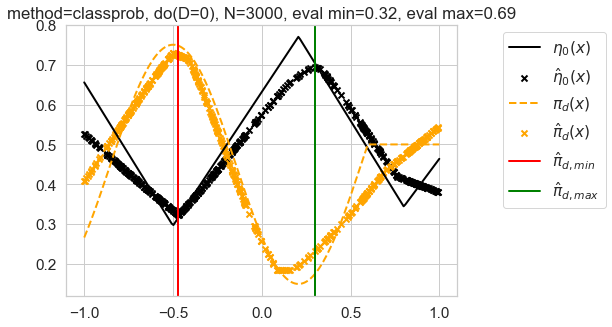

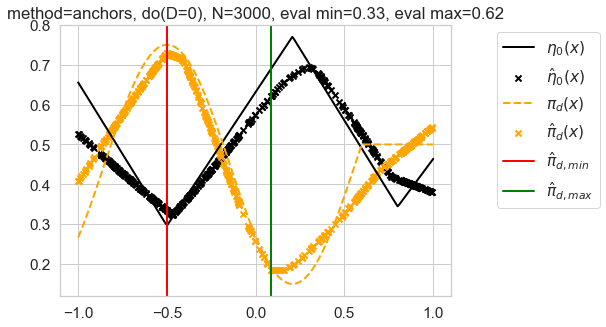

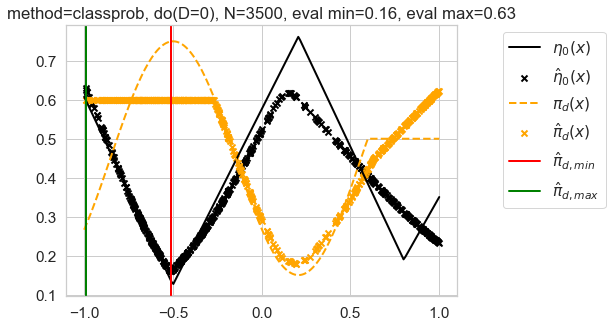

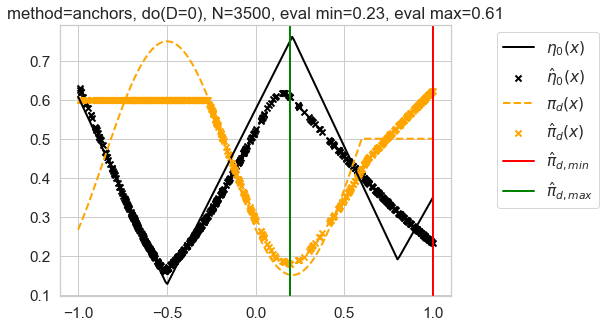

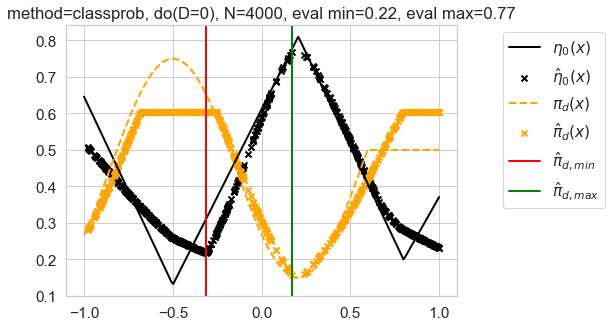

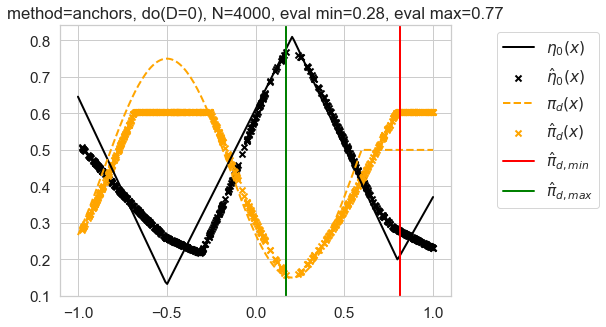

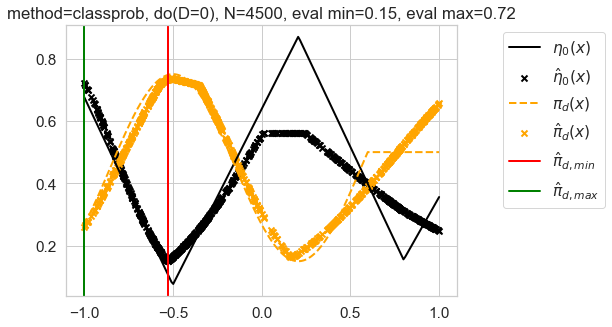

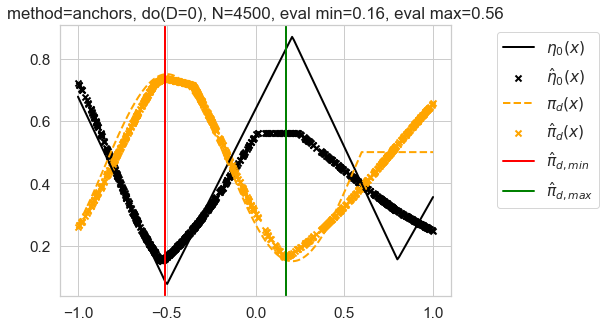

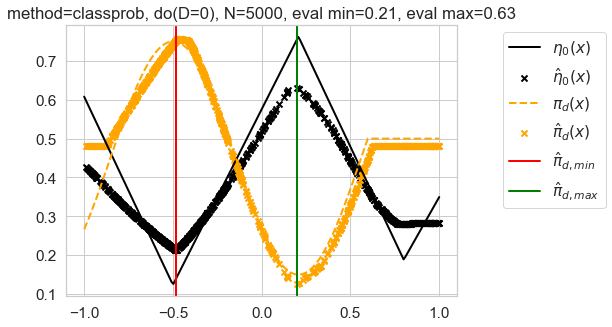

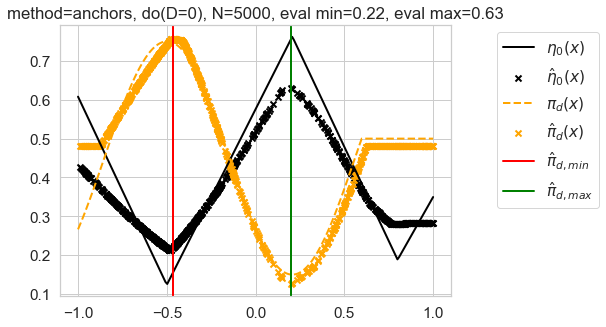

In [206]:
# N=1000

# alpha=.15
# beta=.15

xmin=-1
xmax=1
x = np.linspace(-1,1, num=200)
eta_star = eta(x)

# Configuration
plot=True
propfunc='sine'
# dataset_sizes = [2500, 5000, 10000, 20000, 40000, 50000, 60000]
dataset_sizes = [3000, 3500, 4000, 4500, 5000]

runs = {
    'N': [],
    'alpha': [],
    'alpha_hat': [],
    'beta': [],
    'beta_hat': [], 
    'alpha_error': [], 
    'beta_error': [],
    'total_error': [],
    'method': []
}

for N in dataset_sizes:
    for run in range(1):
        
        alpha = random.uniform(.05, .3)
        beta =  random.uniform(.05, .3)
        
        if run == 0:
            plot=True
        else:
            plot=False

        # Sample data
        xs = np.random.uniform(xmin, xmax, size=N)
        ds = np.random.binomial(1, pi(xs, do=0, propfunc=propfunc)) #make do() instead of draw
        etass = eta(xs)
        eta_y = ccn_model(eta_star, beta=beta, alpha=alpha)
        pysd = ccn_model(etass, beta=beta, alpha=alpha)
        yobs = np.random.binomial(1, pysd)

        exp_dataset = {
            'X': xs,
            'Y': yobs,
            'Yps': yobs, # Next chunk: try propensity scores
            'Ds': ds,
        }
        
        val_x, val_y, val_py, val_pd = learn_eta_hat(do=d, exp_dataset=exp_dataset, method='ce')
        
        if plot:
                 
            # Compute estimates and errors
            pix = pi(val_x, do=d, propfunc=propfunc)
            
            for method in ['classprob', 'anchors']:

                if method=='classprob':
                    ix_min = np.argmin(val_py[:, 1])
                    ix_max = np.argmax(val_py[:, 1])
                elif method=='anchors':
                    ix_min = np.argmax(val_pd[:, 1])
                    ix_max = np.argmin(val_pd[:, 1])
                    
                alpha_hat = val_py[ix_min, 1]
                beta_hat = 1- val_py[ix_max, 1]
            
                alpha_error = np.abs(alpha_hat-alpha)
                beta_error = np.abs(beta_hat-beta)
                total_error = alpha_error+beta_error

                # Track error statistics
                runs['N'].append(N)
                runs['alpha'].append(alpha)
                runs['beta'].append(beta)
                runs['alpha_hat'].append(alpha_hat)
                runs['beta_hat'].append(alpha_hat)
                runs['alpha_error'].append(alpha_error)
                runs['beta_error'].append(beta_error)
                runs['total_error'].append(total_error)
                runs['method'].append(method)
            
                if plot:
                    f, axs = plt.subplots(1, 1, sharey=False, figsize=(7,5))
                    psx = pi(val_x, do=d, propfunc=propfunc)
                    
                    # Class probability functions
                    # axs.plot(x, eta_star, label=f'$\eta^*_{d}(x)$')
                    axs.plot(x, eta_y, label=f'$\eta_{d}(x)$', color='black')
                    axs.scatter(val_x, val_py[:,1], marker='x', color='black', label=f'$\hat \eta_0(x)$')

                    # Propensity function
                    pix = pi(x, do=d, propfunc=propfunc)
                    axs.plot(x, pix.squeeze(), label='$\pi_d(x)$', color='orange', linestyle='--')
                    axs.scatter(val_x, val_pd[:,1], marker='x',  color='orange', label=f'$\hat \pi_d(x)$')

                    axs.axvline(x=val_x[ix_min], color='red', label='$\hat \pi_{d,min}$')
                    axs.axvline(x=val_x[ix_max], color='green', label='$\hat \pi_{d,max}$')

                    plt.title(f'method={method}, do(D={d}), N={N}, eval min={val_py[ix_min, 1]:.2}, eval max={val_py[ix_max, 1]:.2}')
                    plt.legend(bbox_to_anchor=(1.4, 1))
    #                 plt.savefig(f'fig/do(D={d}), N={N} anchors.png', dpi=400, bbox_inches = "tight")



In [203]:
runslog = pd.DataFrame(runs)

runslog=runslog.rename(columns={
    'alpha_error': 'Alpha',
    'beta_error': 'Beta',
}, inplace=False)

data = pd.melt(runslog, id_vars=['N', 'alpha', 'beta', 'alpha_hat', 'beta_hat', 'total_error', 'method'],
        value_vars=['Alpha', 'Beta'], value_name='error')


data.loc[data['method'] == 'classprob', 'method'] = '$\hat \eta_{d,min} / \hat \eta_{d,max}$'
data.loc[data['method'] == 'anchors', 'method'] = '$\hat \pi_{d,min} / \hat \pi_{d,max}$'

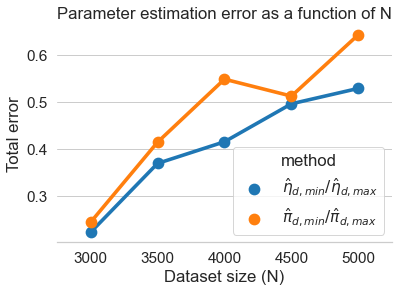

In [207]:
sns.pointplot(data=data, x='N', y='total_error', hue='method')
plt.ylabel('Total error')
plt.xlabel('Dataset size (N)')
plt.title('Parameter estimation error as a function of N')
sns.despine(left=True)
plt.savefig('fig/total_error_methods.png', dpi=400, bbox_inches = "tight")



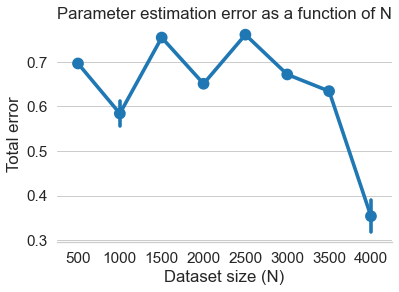

In [165]:
sns.pointplot(data=data, x='N', y='total_error')
plt.ylabel('Total error')
plt.xlabel('Dataset size (N)')
plt.title('Parameter estimation error as a function of N')
sns.despine(left=True)
plt.savefig('fig/total_error.png')

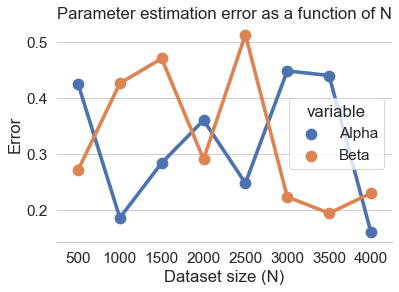

In [169]:
runslog = pd.DataFrame(runs)

runslog=runslog.rename(columns={
    'alpha_error': 'Alpha',
    'beta_error': 'Beta',
}, inplace=False)

data = pd.melt(runslog, id_vars=['N', 'alpha', 'beta', 'alpha_hat', 'beta_hat', 'total_error', 'method'],
        value_vars=['Alpha', 'Beta'], value_name='error')


data = data[data['method']=='anchors']
sns.pointplot(data=data, x='N', y='error', hue='variable', palette="deep")
plt.ylabel('Error')
plt.xlabel('Dataset size (N)')
plt.title('Parameter estimation error as a function of N')
sns.despine(left=True)
plt.savefig('fig/total_alpha_beta_error.png')